In [1]:
#pip install tensorflow

In [2]:

# Load libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot  as plt

from scipy.stats import uniform
from scipy.stats import randint


from sklearn.model_selection import KFold

from math import sqrt
from numpy import asarray
from sklearn.datasets import make_regression

from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

#import tensorflow as tf
#from tensorflow import keras


from numpy import hstack
from numpy import vstack
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

Load Dataset

In [3]:
df = pd.read_csv('IOR_data_final.csv')
df.describe

<bound method NDFrame.describe of      Temperature   SDS  Pressure  Salinity  Viscosity
0            300  0.11       100    0.2437   4.942700
1            300  0.11       100    0.2509   5.135900
2            300  0.11       100    0.2599   5.683300
3            300  0.11       100    0.2687   5.973100
4            300  0.11       100    0.2759   6.327300
..           ...   ...       ...       ...        ...
457          300  0.21       220    0.2801   6.707582
458          300  0.21       220    0.2852   6.679890
459          300  0.21       220    0.2915   6.646885
460          300  0.21       220    0.3001   6.540303
461          300  0.21       220    0.3079   6.279644

[462 rows x 5 columns]>

Dataset Statistics

In [4]:
# shape
df.shape
# head
df.describe()

,Temperature,SDS,Pressure,Salinity,Viscosity
count,462.000000,462.000000,462.000000,462.000000,462.000000
mean,348.138528,0.171212,127.272727,0.280011,6.236311
std,58.938534,0.035608,41.405975,0.031551,0.516467
min,300.000000,0.110000,100.000000,0.219800,4.685100
25%,300.000000,0.150000,100.000000,0.251225,5.880525
50%,300.000000,0.180000,100.000000,0.279900,6.326898
75%,380.000000,0.210000,160.000000,0.305925,6.646764
max,460.000000,0.240000,220.000000,0.342100,7.132300


Dataset Preprocessing

In [5]:
#types
df = df.drop_duplicates()
df = df.dropna( how='all')
df.shape

(462, 5)

Create Test Dataset -Stratify

In [6]:
# Find feature most correlated with the target variable
corr_matrix = df.corr()
abs(corr_matrix['Viscosity']).sort_values(ascending=False)

Viscosity      1.000000
Temperature    0.451343
SDS            0.438982
Pressure       0.318388
Salinity       0.049910
Name: Viscosity, dtype: float64

In [7]:
# categorize values in the feature
df['new_cat'] = pd.qcut(df["Viscosity"], 4, labels=[1, 2, 3,4])
df.head()

,Temperature,SDS,Pressure,Salinity,Viscosity,new_cat
0,300,0.11,100,0.2437,4.9427,1
1,300,0.11,100,0.2509,5.1359,1
2,300,0.11,100,0.2599,5.6833,1
3,300,0.11,100,0.2687,5.9731,2
4,300,0.11,100,0.2759,6.3273,3


In [8]:
train_full, test_full = train_test_split(df, test_size=.2, random_state=42, stratify=df['new_cat'])
df['new_cat'].value_counts() / len(df)

new_cat
1    0.251082
4    0.251082
2    0.248918
3    0.248918
Name: count, dtype: float64

In [9]:
test_full['new_cat'].value_counts() / len(test_full)

new_cat
4    0.258065
1    0.247312
2    0.247312
3    0.247312
Name: count, dtype: float64

In [10]:
train_full.describe()

,Temperature,SDS,Pressure,Salinity,Viscosity
count,369.000000,369.000000,369.000000,369.000000,369.000000
mean,348.455285,0.170650,126.585366,0.279525,6.238270
std,59.032496,0.035472,41.411822,0.031508,0.512573
min,300.000000,0.110000,100.000000,0.221000,4.685100
25%,300.000000,0.150000,100.000000,0.250900,5.876500
50%,300.000000,0.180000,100.000000,0.278900,6.326495
75%,380.000000,0.210000,160.000000,0.305100,6.646402
max,460.000000,0.240000,220.000000,0.342100,7.132300


In [11]:
test_full.describe()

,Temperature,SDS,Pressure,Salinity,Viscosity
count,93.00000,93.000000,93.000000,93.000000,93.000000
mean,346.88172,0.173441,130.000000,0.281938,6.228538
std,58.86570,0.036251,41.493844,0.031822,0.534407
min,300.00000,0.110000,100.000000,0.219800,4.813900
25%,300.00000,0.150000,100.000000,0.255700,5.908700
50%,300.00000,0.180000,100.000000,0.281100,6.327300
75%,380.00000,0.210000,160.000000,0.307700,6.646885
max,460.00000,0.240000,220.000000,0.342100,7.100100


In [12]:
# Seperate output and input variables
drop_list = ["new_cat", "Viscosity"]
train_X, test_X, y_train, y_test = train_full.drop(drop_list, axis=1), test_full.drop(drop_list, axis=1),train_full["Viscosity"], test_full["Viscosity"]

In [13]:
y_test_shap = y_test
y_train_shap = y_train
train_full.drop("new_cat", axis = 1, inplace = True)
test_full.drop("new_cat", axis = 1, inplace = True)

Transform

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train_X)
X_test = scaler.transform(test_X)

In [15]:
y_train= y_train.values.ravel()
y_test = y_test.values.ravel()

Define Utilities

In [16]:
# Create function to evaluate model

def evaluate_model(model, X, y, scoring, cv):
  # evaluate the model with cross-validation and mean squareed error
  scores = cross_val_score(estimator=model, X=X, y=y, 
                           scoring= scoring, cv=cv,
                           n_jobs = -1)
  # Force positive output
  scores = np.abs(scores)
  # Output the result
  print("RMSE: ", scores.mean(), "(", scores.std(), ")")

In [17]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'neg_root_mean_squared_error'
cv = RepeatedKFold(n_splits=num_folds, random_state=seed)

KNN

In [18]:
# define the base model
model = KNeighborsRegressor()

# evaluate model
evaluate_model(model, X_train, y_train,scoring, cv) 

RMSE:  0.22195091161112246 ( 0.03037876590179372 )


Fine-tune Algorithm

In [19]:
# define the base model
model = KNeighborsRegressor() 

param_dist = {
    'n_neighbors' : randint(1, 100),
    # 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : randint(1, 100),
    'p': [1,5]

    }

rnd_search = RandomizedSearchCV(estimator= model, param_distributions=param_dist,cv=cv,
                           scoring=scoring, return_train_score=True, random_state = seed,
                           verbose =2, n_jobs=-1,)
rnd_search.fit(X_train, y_train)

rnd_search.best_params_

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


{'leaf_size': 53, 'n_neighbors': 2, 'p': 5}

In [20]:
# Define base model
model_KNN =rnd_search.best_estimator_

# evaluate model
evaluate_model(model_KNN,X_train, y_train, scoring,cv)

RMSE:  0.22079956072990203 ( 0.029909315335498517 )


In [21]:
# Fit the model on the training set

fitted_KNN = model_KNN.fit(X_train, y_train)
KNN_pred_train = fitted_KNN.predict(X_train)
KNN_pred = fitted_KNN.predict(X_test)
KNN_pred_full = fitted_KNN.predict(X_test)
# evaluate model
evaluate_model(model_KNN,X_test, y_test, scoring,cv)

RMSE:  0.31125528951852455 ( 0.0757242772609562 )


Plot Predicted vs Measured

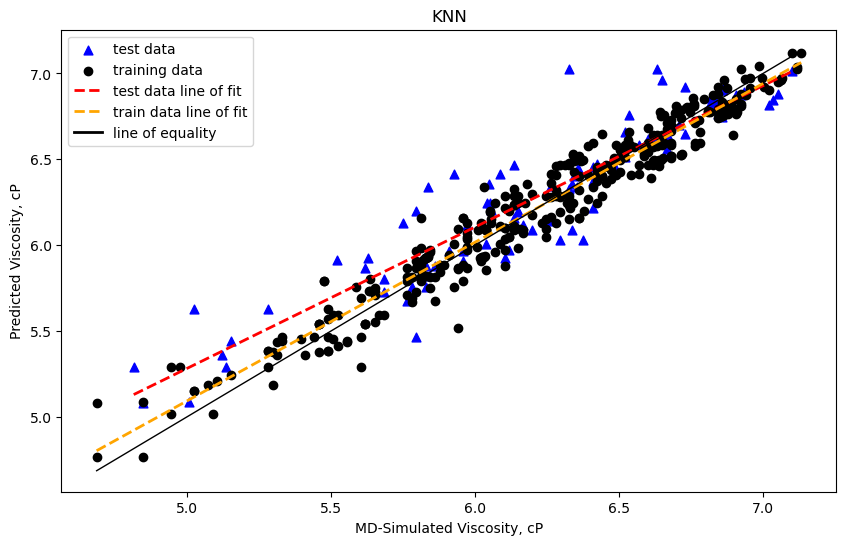

In [22]:
# Plot predicted vs Measured for Apparent Viscosity
predicted = KNN_pred_train
predicted2 = KNN_pred

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, predicted2 , c='blue', marker = "^", s = 40, label ='test data ')
ax.scatter(y_train, predicted, c= 'black', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1).flatten())(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1).flatten())(np.unique(y_train)),color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('KNN')
ax.set_xlabel('MD-Simulated Viscosity, cP')
ax.set_ylabel('Predicted Viscosity, cP')

r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3 )}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3 )}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2,line3])

plt.legend(handles=handles)
plt.savefig('viscosity_KNN1.png', dpi=300, bbox_inches='tight')
plt.show()

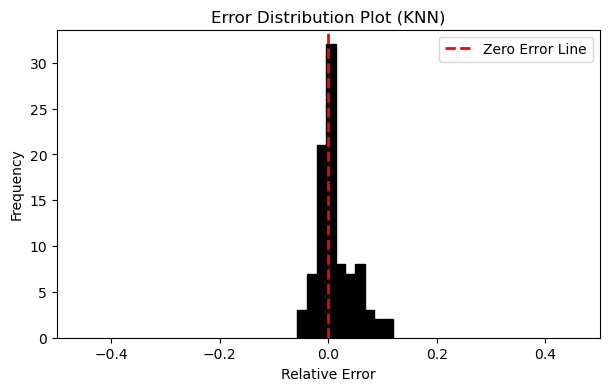

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the relative errors
relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(7, 4))
plt.hist(relative_errors, bins=10, edgecolor='k', color='black')
plt.title('Error Distribution Plot (KNN)')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(False)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

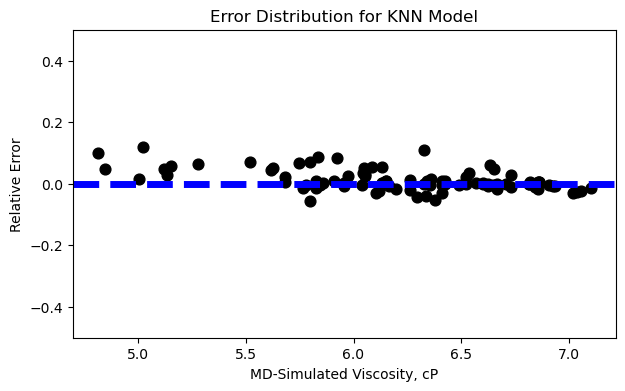

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(7, 4))
plt.scatter(y_test, relative_errors, c='black', marker='o', s=60)
plt.axhline(0, color='blue', linestyle='--', lw=5)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for KNN Model')
plt.xlabel('MD-Simulated Viscosity, cP')
plt.ylabel('Relative Error')
plt.grid(False)
plt.savefig('viscosity_KNN2.png', dpi=300, bbox_inches='tight')
plt.show()

SVR

In [25]:
# define the base model
model = SVR()

# evaluate model
evaluate_model (model, X_train, y_train,scoring, cv)

RMSE:  0.17309112102437282 ( 0.02631164697303888 )


Fine-tune Algorithm

In [26]:
# define the base model
model = SVR() 

# define hyperparameter values
param_dist = {
    # "kernel": ['linear', 'sigmoid','poly', 'rbf', ],
    'C' : randint(1, 100),
    'gamma' : uniform(0.01,2.0),
    'kernel': ['rbf']
    #'degree' : (0.1,10),
    
    }

# Implement randomized search on hyper parameters
rnd_search = RandomizedSearchCV(estimator= model, param_distributions=param_dist,cv=cv,
                           scoring=scoring, return_train_score=True, random_state = seed,
                           verbose =2, n_jobs=-1)

# Fit to training dataset
rnd_search.fit(X_train, y_train)

rnd_search.best_params_

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


{'C': 33, 'gamma': 0.6184844859190755, 'kernel': 'rbf'}

In [27]:
# Define base model
model_SVR =rnd_search.best_estimator_

# evaluate model
evaluate_model(model_SVR, X_train, y_train, scoring, cv)

RMSE:  0.11983798113464246 ( 0.01329227464429857 )


In [28]:
modelu = SVR().fit(X_train, y_train)
# Fit the model on the training set and time the execution
fitted_SVR = model_SVR.fit(X_train, y_train)

#predict using training data
SVR_pred_train = fitted_SVR.predict(X_train)

#predict using test data
SVR_pred = fitted_SVR.predict(X_test)

# evaluate model
evaluate_model (model_SVR, X_test, y_test,scoring, cv)

RMSE:  0.20802470613096463 ( 0.054253805179543584 )


Plot Predicted vs Measured

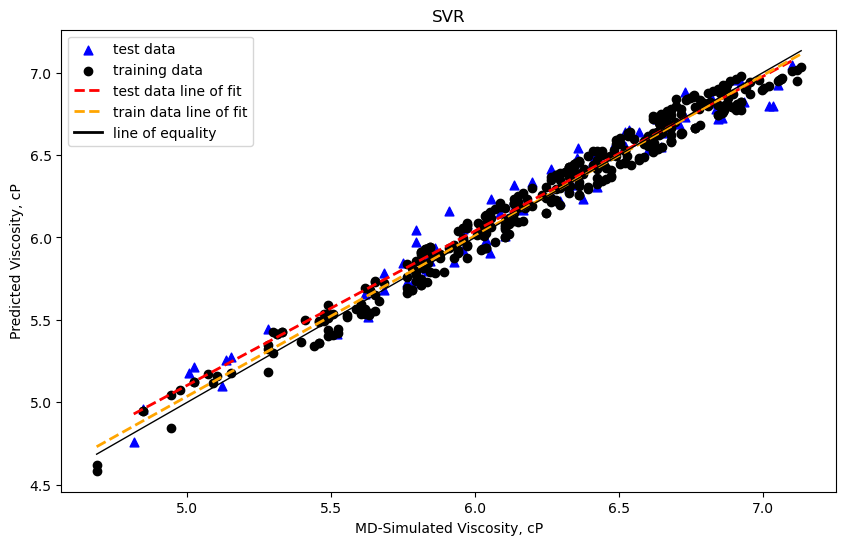

In [29]:
# Plot predicted vs Measured for Apparent Viscosity
predicted = SVR_pred_train
predicted2 = SVR_pred

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, predicted2 , c='blue', marker = "^", s = 40, label ='test data ')
ax.scatter(y_train, predicted, c= 'black', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1).flatten())(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1).flatten())(np.unique(y_train)),color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('SVR')
ax.set_xlabel('MD-Simulated Viscosity, cP')
ax.set_ylabel('Predicted Viscosity, cP')

r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3 )}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3 )}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2,line3])

plt.legend(handles=handles)
plt.savefig('viscosity_SVR1.png', dpi=300, bbox_inches='tight')
plt.show()

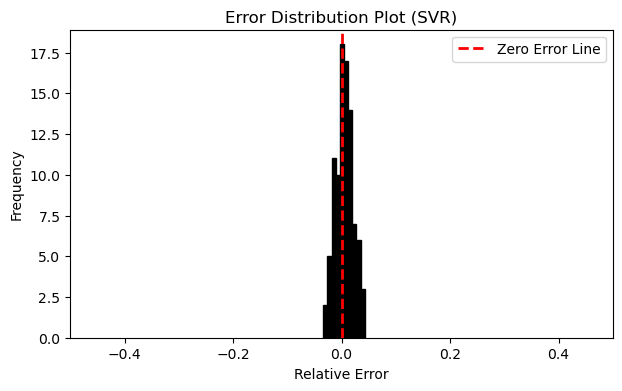

In [30]:
# Calculate the relative errors

relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(7, 4))
plt.hist(relative_errors, bins=10, edgecolor='k', color='black')
plt.title('Error Distribution Plot (SVR)')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(False)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

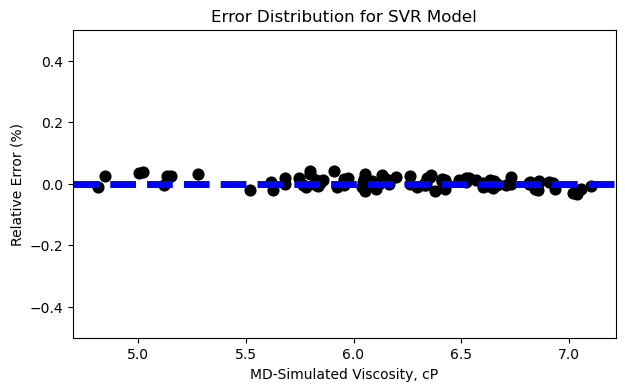

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(7, 4))
plt.scatter(y_test, relative_errors, c='black', marker='o', s=60)
plt.axhline(0, color='blue', linestyle='--', lw=5)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for SVR Model')
plt.xlabel('MD-Simulated Viscosity, cP')
plt.ylabel('Relative Error (%)')
plt.grid(False)
plt.savefig('viscosity_SVR2.png', dpi=300, bbox_inches='tight')
plt.show()

Feature Importance

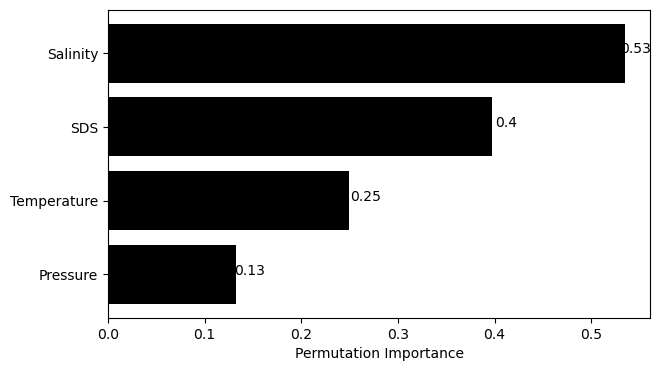

In [32]:
# perform permutation importance
results = permutation_importance(model_SVR, X_train, y_train,
                                 scoring='neg_root_mean_squared_error', 
                                 n_repeats=10, n_jobs=-1, random_state=42)
# get importance
feature_importance = results.importances_mean



sorted_feat= sorted(zip(feature_importance, train_X), reverse=False)

# Create two lists from the list of tuples created
value,name = [list(c) for c in zip(*sorted_feat)]

# Plot the features
f = plt.figure(figsize=(7,4))
plt.barh(y = name, width= value, color= 'black')

for index, value in enumerate(value):
  value = round(value,2)
  plt.text(value, index, str(value))

plt.xlabel('Permutation Importance')
# plt.ylabel(' Features ')
plt.show()

Polynomial Regression

In [33]:
degree = 4
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

# define the base model
model_PR = LinearRegression()

# evaluate model
evaluate_model(model_PR, X_train_poly, y_train,scoring, cv)

RMSE:  0.15419348748895567 ( 0.020656240515458273 )


In [34]:

# Fit the model on the training set and time the execution
fitted_PR = model_PR.fit(X_train_poly, y_train)

#predict using training data
PR_pred_train = fitted_PR.predict(X_train_poly)

#predict using test data
PR_pred = fitted_PR.predict(X_test_poly)

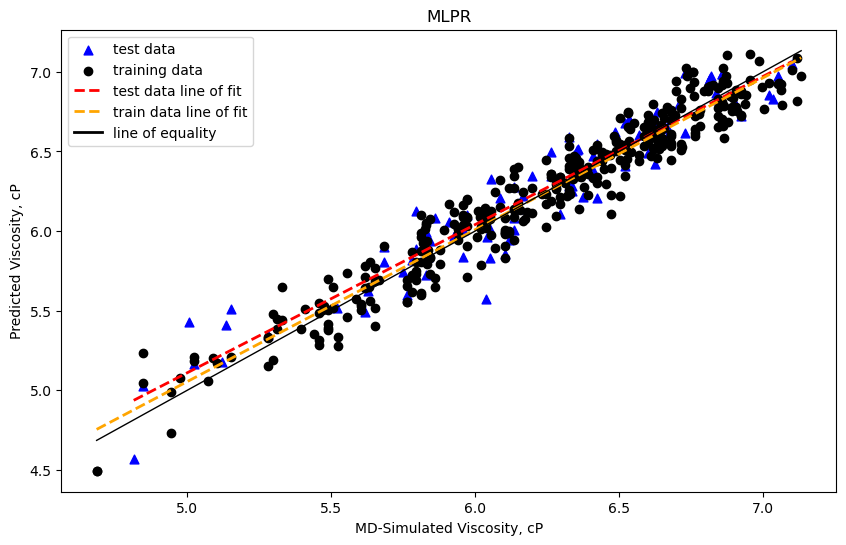

In [35]:
# Plot predicted vs Measured for Apparent Viscosity
predicted = PR_pred_train
predicted2 = PR_pred

fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(y_test, predicted2 , c='blue', marker = "^", s = 40, label ='test data ')
ax.scatter(y_train, predicted, c= 'black', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1))(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1))(np.unique(y_train)),color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('MLPR')
ax.set_xlabel('MD-Simulated Viscosity, cP')
ax.set_ylabel('Predicted Viscosity, cP')

r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3 )}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3 )}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2,line3])

plt.legend(handles=handles)
plt.savefig('viscosity_MLPR1.png', dpi=300, bbox_inches='tight')
plt.show()

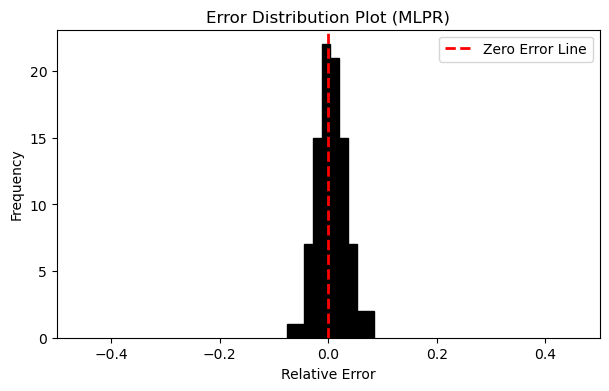

In [36]:
# Calculate the relative errors
relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(7, 4))
plt.hist(relative_errors, bins=10, edgecolor='k', color='black')
plt.title('Error Distribution Plot (MLPR)')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(False)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

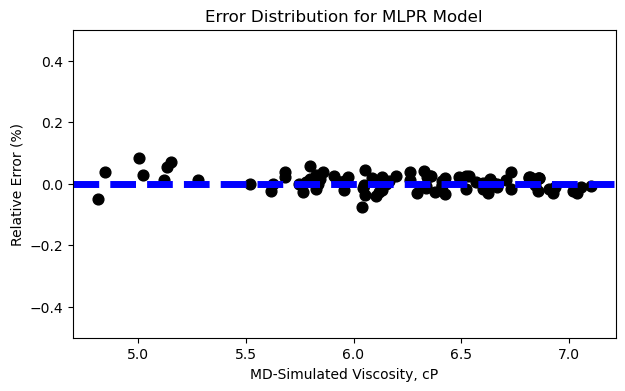

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(7, 4))
plt.scatter(y_test, relative_errors, c='black', marker='o', s=60)
plt.axhline(0, color='b', linestyle='--', lw=5)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for MLPR Model')
plt.xlabel('MD-Simulated Viscosity, cP')
plt.ylabel('Relative Error (%)')
plt.grid(False)
plt.savefig('viscosity_MLPR2.png', dpi=300, bbox_inches='tight')
plt.show()

MLPNN

#Create function to build and compile a Keras model
from tensorflow.keras.constraints import max_norm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, RMSprop


def build_model(n_hidden=1, n_neurons=20, learning_rate = 2e-3, input_shape = X_train.shape[1:]): # explicitly state no of features as input_shape
  model = Sequential()
  options = {"input_shape": input_shape}

  for layer in range(n_hidden):
    model.add(Dense(n_neurons, activation="relu", 

                    **options))
    options ={} # so that input_shape option only applies to first layer

  model.add(Dense(1, activation="linear",  

                  **options)) #output layer

  optimizer = RMSprop(learning_rate)
  model.compile(loss = "mse", optimizer = optimizer) # mse represents l2 loss

  return model

model_ANN = build_model()
fitted_ANN = model_ANN.fit(X_train, y_train,
        epochs = 300, batch_size = 20,
        validation_split = 0.2,
        callbacks=[keras.callbacks.EarlyStopping(patience=10)], verbose =0)

model_ANN.summary()
# summarize history for loss
plt.plot(fitted_ANN.history['loss'])
plt.plot(fitted_ANN.history[ 'val_loss' ])
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train ', 'val_loss' ], loc= 'upper right' )
plt.show()

model_ANN.evaluate(X_train,y_train)

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

ANN_pred_train = model_ANN.predict(X_train)
ANN_pred = model_ANN.predict(X_test)

print (mean_squared_error(y_train,ANN_pred_train, squared=False))
print (mean_squared_error(y_test,ANN_pred, squared=False))

# Plot predicted vs Measured for Apparent Viscosity

predicted = ANN_pred_train
predicted2 = ANN_pred

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, predicted2 , c='blue', marker = "^", s = 40, label ='test data ')
ax.scatter(y_train, predicted, c= 'green', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1).flatten())(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1).flatten())(np.unique(y_train)),color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('MLPNN')
ax.set_xlabel('Measured Viscosity, cP')
ax.set_ylabel('Predicted Viscosity, cP')


r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3 )}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3 )}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2,line3,text1, text2])

plt.legend(handles=handles)

plt.show()

# Calculate the relative errors
relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.hist(relative_errors, bins=10, edgecolor='k')
plt.title('Error Distribution Plot')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(True)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, relative_errors, c='blue', marker='o', s=40)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for MLPNN Model')
plt.xlabel('Measured Viscosity, cP')
plt.ylabel('Relative Error (%)')
plt.grid(True)

plt.show()

CART

In [38]:
# define the base model
model = DecisionTreeRegressor()

# wrapper = MultiOutputRegressor(model)
evaluate_model(model, X_train, y_train,scoring, cv)

RMSE:  0.17413528355793337 ( 0.030299361634723854 )


Fine-tune Algorithm

In [39]:
# define the base model
model = DecisionTreeRegressor(random_state= 42,) 

param_dist = {
    "max_depth": randint(2, 20),
    "min_samples_split": randint(2, 15),
    # 'min_samples_leaf' : randint(1, 100),
    # # 'max_features' : ["auto", "sqrt", "log2"],
    # "max_leaf_nodes": randint(2, 100),
    }

rnd_search = RandomizedSearchCV(estimator= model, param_distributions=param_dist,cv=cv,
                           scoring=scoring, return_train_score=True, random_state = seed,
                           verbose =2, n_jobs=-1,)
rnd_search.fit(X_train, y_train)

rnd_search.best_params_

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


{'max_depth': 13, 'min_samples_split': 7}

In [40]:
# Define model
model_CART =rnd_search.best_estimator_

# evaluate model
evaluate_model(model_CART,X_train, y_train, scoring,cv)

RMSE:  0.18641215757691948 ( 0.029332165118452786 )


In [41]:
# Fit the model on the training set
fitted_CART = model_CART.fit(X_train, y_train)

In [42]:
CART_pred_train = fitted_CART.predict(X_train)
CART_pred = fitted_CART.predict(X_test)

In [43]:
# evaluate model
evaluate_model(model_CART,X_test, y_test, scoring,cv)

RMSE:  0.39264273618641804 ( 0.1188159162084011 )


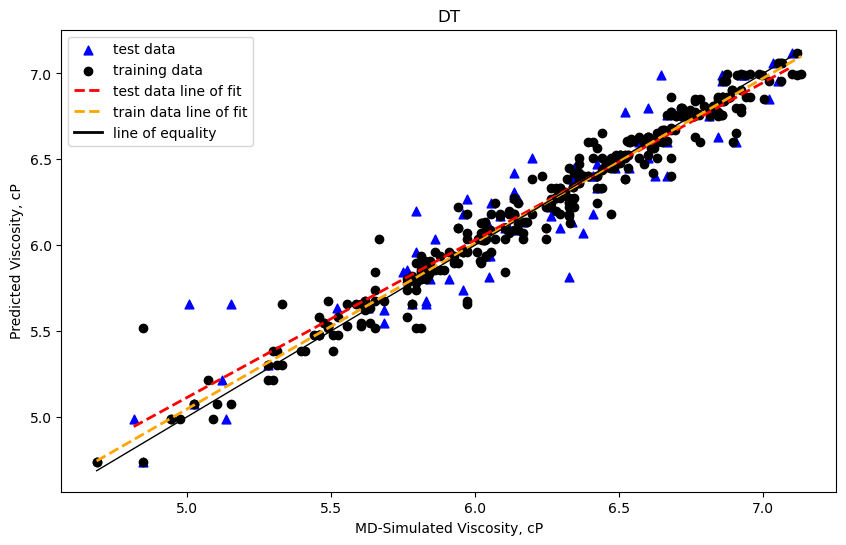

In [44]:
# Plot predicted vs Measured for Apparent Viscosity

predicted = CART_pred_train
predicted2 = CART_pred

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, predicted2 , c='blue', marker = "^", s = 40, label ='test data ')
ax.scatter(y_train, predicted, c= 'black', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1).flatten())(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1).flatten())(np.unique(y_train)),color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('DT')
ax.set_xlabel('MD-Simulated Viscosity, cP')
ax.set_ylabel('Predicted Viscosity, cP')


r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3 )}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3 )}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2,line3])

plt.legend(handles=handles)
plt.savefig('viscosity_DT1.png', dpi=300, bbox_inches='tight')
plt.show()

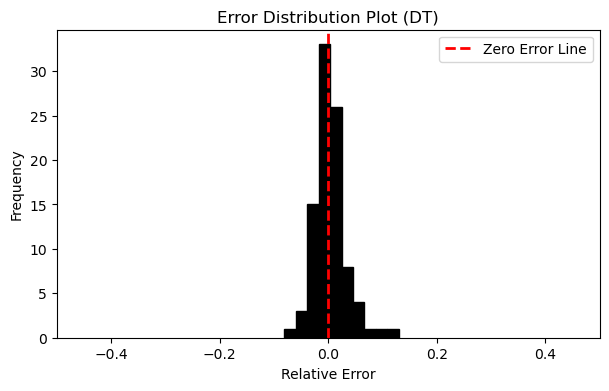

In [45]:
# Calculate the relative errors
relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(7, 4))
plt.hist(relative_errors, bins=10, edgecolor='k', color='black')
plt.title('Error Distribution Plot (DT)')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(False)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

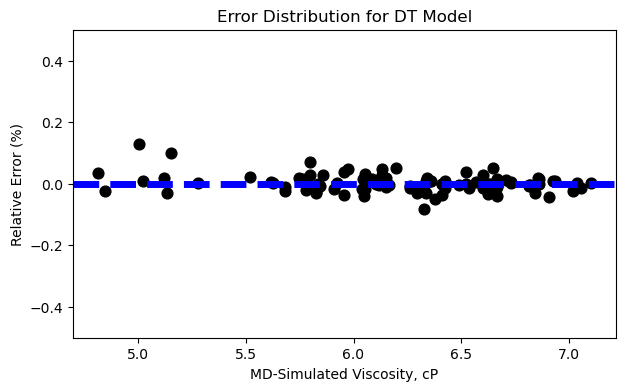

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(7, 4))
plt.scatter(y_test, relative_errors, c='black', marker='o', s=60)
plt.axhline(0, color='blue', linestyle='--', lw=5)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for DT Model')
plt.xlabel('MD-Simulated Viscosity, cP')
plt.ylabel('Relative Error (%)')
plt.grid(False)
plt.savefig('viscosity_DT2.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
# Define model
model_CART =rnd_search.best_estimator_

# evaluate model
evaluate_model(model_CART,X_train, y_train, scoring,cv)

RMSE:  0.18641215757691948 ( 0.029332165118452786 )


In [48]:
pip show lightgbm

Name: lightgbmNote: you may need to restart the kernel to use updated packages.

Version: 4.6.0
Summary: LightGBM Python-package
Home-page: https://github.com/microsoft/LightGBM
Author: 
Author-email: 
License: The MIT License (MIT)

Copyright (c) Microsoft Corporation

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTI

LightGBM

In [49]:
#!pip install lightgbm

# Import LightGBM
from lightgbm import LGBMRegressor

# Define the base model
model = LGBMRegressor()

# Evaluate model
evaluate_model(model, X_train, y_train, scoring, cv)

param_dist = {
    'n_estimators': randint(1, 100),
    'num_leaves': randint(1, 10),
    'min_child_samples': randint(2, 10),
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': uniform(loc=0.2, scale=0.8),
    'colsample_bytree': uniform(loc=0.4, scale=0.6),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

rnd_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=cv,
                                scoring=scoring, return_train_score=True, random_state=seed,
                                verbose=2, n_jobs=-1)
rnd_search.fit(X_train, y_train)

rnd_search.best_params_  # Define base model



RMSE:  0.16349182108310445 ( 0.02655271053024991 )
Fitting 100 folds for each of 10 candidates, totalling 1000 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 369, number of used features: 4
[LightGBM] [Info] Start training from score 6.238270


{'colsample_bytree': 0.9767032146096095,
 'min_child_samples': 6,
 'min_child_weight': 0.001,
 'n_estimators': 53,
 'num_leaves': 8,
 'reg_alpha': 0.1,
 'reg_lambda': 0,
 'subsample': 0.4247476077499046}

RMSE:  0.16145999604743497 ( 0.02791842778092631 )
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 369, number of used features: 4
[LightGBM] [Info] Start training from score 6.238270
RMSE:  0.2691423082008512 ( 0.06617318747819276 )


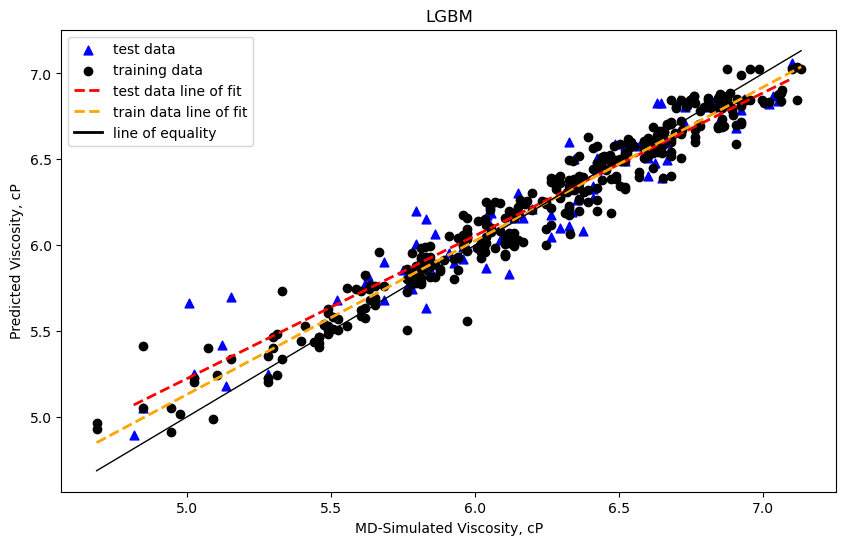

In [50]:
model_LGBM = rnd_search.best_estimator_
# Evaluate model
evaluate_model(model_LGBM, X_train, y_train, scoring, cv)  # Fit the model on the training set

fitted_LGBM = model_LGBM.fit(X_train, y_train)
LGBM_pred_train = fitted_LGBM.predict(X_train)
LGBM_pred = fitted_LGBM.predict(X_test)
LGBM_pred_full = fitted_LGBM.predict(X_test)
# Evaluate model
evaluate_model(model_LGBM, X_test, y_test, scoring, cv)  # Plot predicted vs Measured for Apparent Viscosity
predicted = LGBM_pred_train
predicted2 = LGBM_pred

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_test, predicted2, c='blue', marker="^", s=40, label='test data')
ax.scatter(y_train, predicted, c='black', label='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1).flatten())(np.unique(y_test)), color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1).flatten())(np.unique(y_train)), color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title('LGBM')
ax.set_xlabel('MD-Simulated Viscosity, cP')
ax.set_ylabel('Predicted Viscosity, cP')

r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3)}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3)}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2, line3])

plt.legend(handles=handles)
plt.savefig('viscosity_LGBM1.png', dpi=300, bbox_inches='tight')
plt.show()

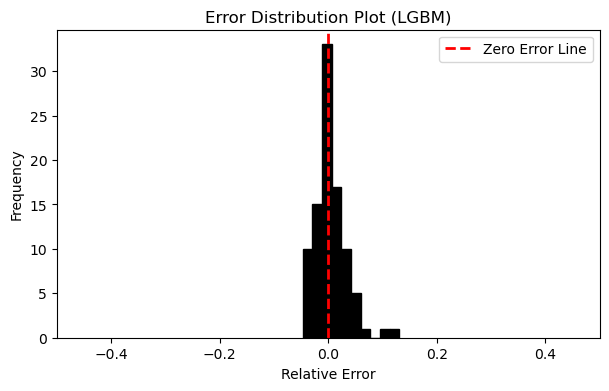

In [51]:
# Calculate the relative errors
relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(7, 4))
plt.hist(relative_errors, bins=10, edgecolor='k', color='black')
plt.title('Error Distribution Plot (LGBM)')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(False)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

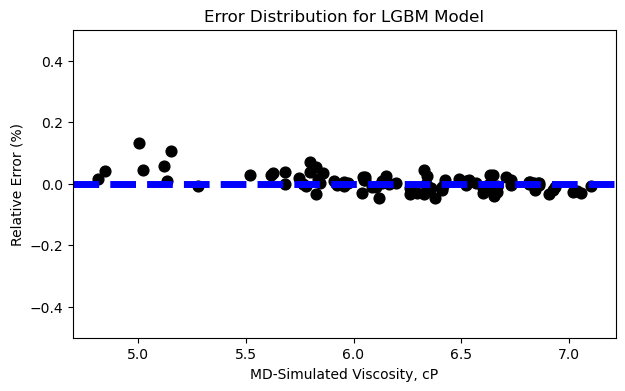

In [52]:
# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(7, 4))
plt.scatter(y_test, relative_errors, c='black', marker='o', s=60)
plt.axhline(0, color='blue', linestyle='--', lw=5)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for LGBM Model')
plt.xlabel('MD-Simulated Viscosity, cP')
plt.ylabel('Relative Error (%)')
plt.grid(False)
plt.savefig('viscosity_LGBM2.png', dpi=300, bbox_inches='tight')
plt.show()

Ensemble Methods

Super-learner

# create a list of base-models
def get_models():
	models = []
	models.append(('SVR', model_SVR))
	models.append(('PR', model_PR)) 
	models.append(('MLPNN', model_ANN))
	models.append(('CART', model_CART))
	models.append(('KNN', model_KNN))

	return models

# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
	meta_X, meta_y = list(), list()
 
	# define split of data
	kfold = KFold(n_splits=10, shuffle=True)
 
	# enumerate splits
	for train_ix, test_ix in kfold.split(X):
		fold_yhats = list()
		# get data
		train_X, test_X = X[train_ix], X[test_ix] 
		train_y, test_y = y[train_ix], y[test_ix]
		meta_y.extend(test_y)
	
		# fit and make predictions with each sub-model
		for name,model in models:
			if name == 'PR':
				X_train_poly = PolynomialFeatures(degree=degree).fit_transform(train_X)
				test_X_poly = PolynomialFeatures(degree=degree).fit_transform(test_X)
		
				model.fit(X_train_poly, train_y)
				yhat = model.predict(test_X_poly)
		
			elif name == 'ANN':
				model.fit(train_X, train_y, epochs = 500, batch_size = 20, 
					validation_split = 0.2,callbacks=[keras.callbacks.EarlyStopping(patience=10)], verbose=0)
				yhat = model.predict(test_X)
		
			else:
				model.fit(train_X, train_y)
				yhat = model.predict(test_X)			

			# store columns
			fold_yhats.append(yhat.reshape(len(yhat),1))
		# store fold yhats as columns
		meta_X.append(hstack(fold_yhats))
	return vstack(meta_X), asarray(meta_y)

# fit all base models on the training dataset
def fit_base_models(X, y, models):
	
	for name,model in models:
		if name == 'PR':
			# fit in training set
			X_poly = PolynomialFeatures(degree=degree).fit_transform(X)
			model.fit(X_poly, y)
	 
		elif name == 'ANN':
			model.fit(X, y, epochs = 500, batch_size = 20, 
         validation_split = 0.2,callbacks=[keras.callbacks.EarlyStopping(patience=10)], verbose=0)
		else:
			# fit in training set
			model.fit(X, y)	

# fit a meta model
def fit_meta_model(X, y):
	model = LinearRegression()
	model.fit(X, y)
	return model

# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
	for name, model in models:
		if name == 'PR':
			X_poly = PolynomialFeatures(degree=degree).fit_transform(X)
			yhat = model.predict(X_poly)
		
		else:
			yhat = model.predict(X)

		mse = mean_squared_error(y, yhat, squared=False)
		# print('%s: RMSE %.3f' % (name, (mse)))
	

# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for name, model in models:
		if name == 'PR':
			X_poly = PolynomialFeatures(degree=degree).fit_transform(X)
			yhat = model.predict(X_poly)

		else:
			yhat = model.predict(X)
		
		meta_X.append(yhat.reshape(len(yhat),1))
	meta_X = hstack(meta_X)
 
	# predict
	yhat_meta = meta_model.predict(meta_X)

	return yhat_meta


X,y = X_train, y_train
X_val, y_val = X_test, y_test 

# get models
models = get_models()

# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)

# fit base models
fit_base_models(X, y, models)

# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)

# evaluate base models
evaluate_models(X_val, y_val, models)

# evaluate meta model
Super_pred = super_learner_predictions(X_val, models, meta_model)

# evaluate meta model
Super_pred_train = super_learner_predictions(X, models, meta_model)

# Plot predicted vs Measured for Apparent Viscosity

predicted = Super_pred_train
predicted2 = Super_pred

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, predicted2 , c='blue', marker = "^", s = 40, label ='test data ')
ax.scatter(y_train, predicted, c= 'green', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1).flatten())(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1).flatten())(np.unique(y_train)),color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('Superlearner')
ax.set_xlabel('Measured Apparent Viscosity, cP')
ax.set_ylabel('Predicted Apparent Viscosity, cP')


r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3 )}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3 )}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2,line3,text1, text2])

plt.legend(handles=handles)

plt.show()

# Calculate the relative errors
relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.hist(relative_errors, bins=10, edgecolor='k')
plt.title('Error Distribution Plot')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(True)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, relative_errors, c='blue', marker='o', s=40)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for SUPERLEARNER Model')
plt.xlabel('Measured Viscosity, cP')
plt.ylabel('Relative Error (%)')
plt.grid(True)

plt.show()

Superlearner

In [53]:
# Create a list of base-models
def get_models():
	models = []
	models.append(('SVR', model_SVR))
	models.append(('PR', model_PR)) 
	models.append(('LightGBM', model_LGBM))  # Replaced MLPNN with LightGBM
	models.append(('CART', model_CART))
	models.append(('KNN', model_KNN))

	return models

# Collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
	meta_X, meta_y = list(), list()
 
	# Define split of data
	kfold = KFold(n_splits=10, shuffle=True)
 
	# Enumerate splits
	for train_ix, test_ix in kfold.split(X):
		fold_yhats = list()
		# Get data
		train_X, test_X = X[train_ix], X[test_ix] 
		train_y, test_y = y[train_ix], y[test_ix]
		meta_y.extend(test_y)
	
		# Fit and make predictions with each sub-model
		for name, model in models:
			if name == 'PR':
				X_train_poly = PolynomialFeatures(degree=degree).fit_transform(train_X)
				test_X_poly = PolynomialFeatures(degree=degree).fit_transform(test_X)
		
				model.fit(X_train_poly, train_y)
				yhat = model.predict(test_X_poly)
		
			else:
				model.fit(train_X, train_y)
				yhat = model.predict(test_X)			

			# Store columns
			fold_yhats.append(yhat.reshape(len(yhat),1))
		# Store fold yhats as columns
		meta_X.append(hstack(fold_yhats))
	return vstack(meta_X), asarray(meta_y)

# Fit all base models on the training dataset
def fit_base_models(X, y, models):
	
	for name, model in models:
		if name == 'PR':
			# Fit in training set
			X_poly = PolynomialFeatures(degree=degree).fit_transform(X)
			model.fit(X_poly, y)
	 
		else:
			# Fit in training set
			model.fit(X, y)	

# Fit a meta model
def fit_meta_model(X, y):
	model = LinearRegression()
	model.fit(X, y)
	return model

# Evaluate a list of models on a dataset
def evaluate_models(X, y, models):
	for name, model in models:
		if name == 'PR':
			X_poly = PolynomialFeatures(degree=degree).fit_transform(X)
			yhat = model.predict(X_poly)
		
		else:
			yhat = model.predict(X)

		mse = mean_squared_error(y, yhat, squared=False)
		# print('%s: RMSE %.3f' % (name, (mse)))
	

# Make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for name, model in models:
		if name == 'PR':
			X_poly = PolynomialFeatures(degree=degree).fit_transform(X)
			yhat = model.predict(X_poly)

		else:
			yhat = model.predict(X)
		
		meta_X.append(yhat.reshape(len(yhat),1))
	meta_X = hstack(meta_X)
 
	# Predict
	yhat_meta = meta_model.predict(meta_X)

	return yhat_meta
X,y = X_train, y_train
X_val, y_val = X_test, y_test 

# get models
models = get_models()

# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)

# fit base models
fit_base_models(X, y, models)

# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)

# evaluate base models
evaluate_models(X_val, y_val, models)

# evaluate meta model
Super_pred = super_learner_predictions(X_val, models, meta_model)

# evaluate meta model
Super_pred_train = super_learner_predictions(X, models, meta_model)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 332, number of used features: 4
[LightGBM] [Info] Start training from score 6.248770
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 332, number of used features: 4
[LightGBM] [Info] Start training from score 6.236261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 332, nu

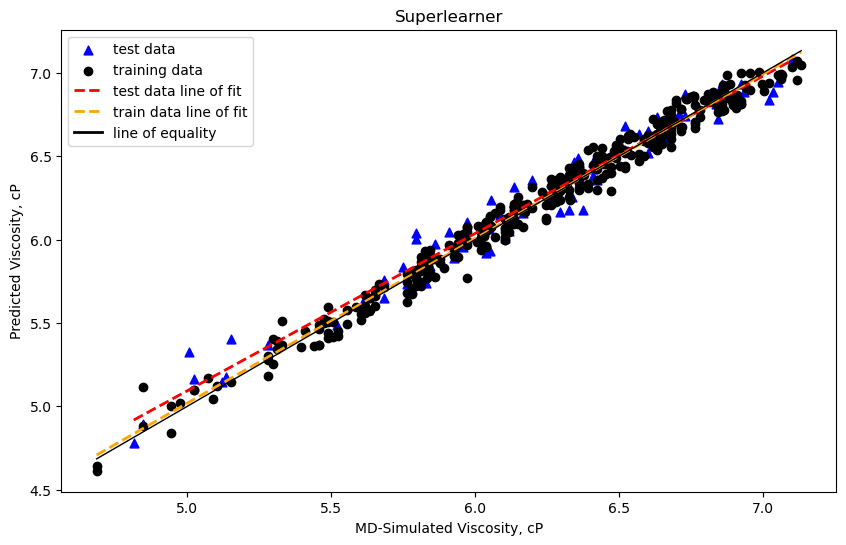

In [54]:
# Plot predicted vs Measured for Apparent Viscosity

predicted = Super_pred_train
predicted2 = Super_pred

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, predicted2 , c='blue', marker = "^", s = 40, label ='test data ')
ax.scatter(y_train, predicted, c= 'black', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1).flatten())(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1).flatten())(np.unique(y_train)),color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('Superlearner')
ax.set_xlabel('MD-Simulated Viscosity, cP')
ax.set_ylabel('Predicted Viscosity, cP')


r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3 )}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3 )}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2,line3])

plt.legend(handles=handles)
plt.savefig('viscosity_SL1.png', dpi=300, bbox_inches='tight')
plt.show()

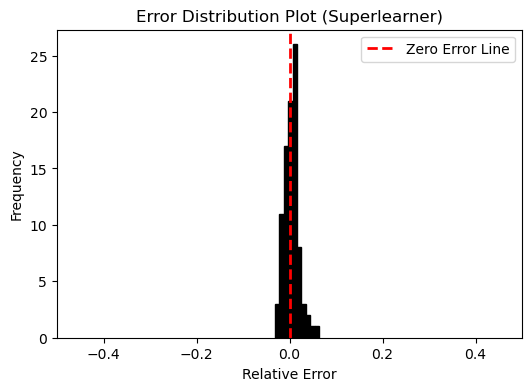

In [55]:
# Calculate the relative errors
relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(6, 4))
plt.hist(relative_errors, bins=10, edgecolor='k', color='black')
plt.title('Error Distribution Plot (Superlearner)')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(False)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

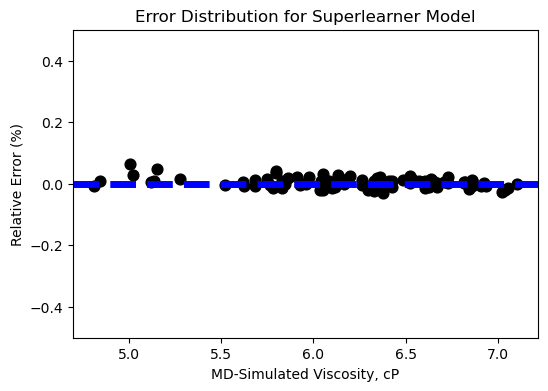

In [56]:
# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, relative_errors, c='black', marker='o', s=60)
plt.axhline(0, color='blue', linestyle='--', lw=5)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for Superlearner Model')
plt.xlabel('MD-Simulated Viscosity, cP')
plt.ylabel('Relative Error (%)')
plt.grid(False)
plt.savefig('viscosity_SL2.png', dpi=300, bbox_inches='tight')
plt.show()

Blended

In [57]:
# get a list of base models
def get_models():
	models = []
	
	models.append(('SVR', model_SVR))
	models.append(('PR', model_PR)) 
	models.append(('LightGBM', model_LGBM))
	models.append(('CART', model_CART))
	models.append(('KNN', model_KNN))

	return models

# fit the blending ensemble
def fit_ensemble(models, X_train, X_test, y_train, y_test):
	# fit all models on the training set and predict on hold out set
	meta_X = list()
 
	for name,model in models:
		if name == 'PR':
			# fit in training set
			X_train_poly1 = PolynomialFeatures(degree=degree).fit_transform(X_train)
			model.fit(X_train_poly1, y_train)
		elif name == 'LightGBM':
			model.fit(X_train, y_train)
		else:
			# fit in training set
			model.fit(X_train, y_train)	 
	
		# predict on test set

	for name,model in models:
		if name == 'PR':
			X_poly= PolynomialFeatures(degree=degree).fit_transform(X_test)
			yhat = model.predict(X_poly) 
		else:
			yhat = model.predict(X_test)
		
	
		mse = mean_squared_error(y_test, yhat, squared=False)
		# print('%s: RMSE %.3f' % (name, (mse)))
		
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
	
		# store predictions as input for blending
		meta_X.append(yhat)
	
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
 
	# define blending model
	blender = (SVR(C= 83, gamma= 0.15996237372700434, kernel= 'rbf'))

	# fit on predictions from base models
	blender.fit(meta_X, y_test)
	return blender

# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
	
	# make predictions with base models
	meta_X = list()
	for name ,model in models:
		
		# predict with base model
		if name == 'PR':
			X_poly= PolynomialFeatures(degree=degree).fit_transform(X_test)
			yhat = model.predict(X_poly)
		else:
			yhat = model.predict(X_test)

		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		
		# store prediction
		meta_X.append(yhat)
	
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	
	# predict
	return blender.predict(meta_X)

# # define dataset

X,y = X_train, y_train
X_test, y_test = X_test, y_test 

# create the base models
models = get_models()

# train the blending ensemble
blender = fit_ensemble(models, X, X_test, y, y_test)

blender2 = fit_ensemble(models, X, X, y, y)

Blended_pred = predict_ensemble(models, blender, X_test)

Blended_pred_train = predict_ensemble(models, blender2, X_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 369, number of used features: 4
[LightGBM] [Info] Start training from score 6.238270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 369, number of used features: 4
[LightGBM] [Info] Start training from score 6.238270


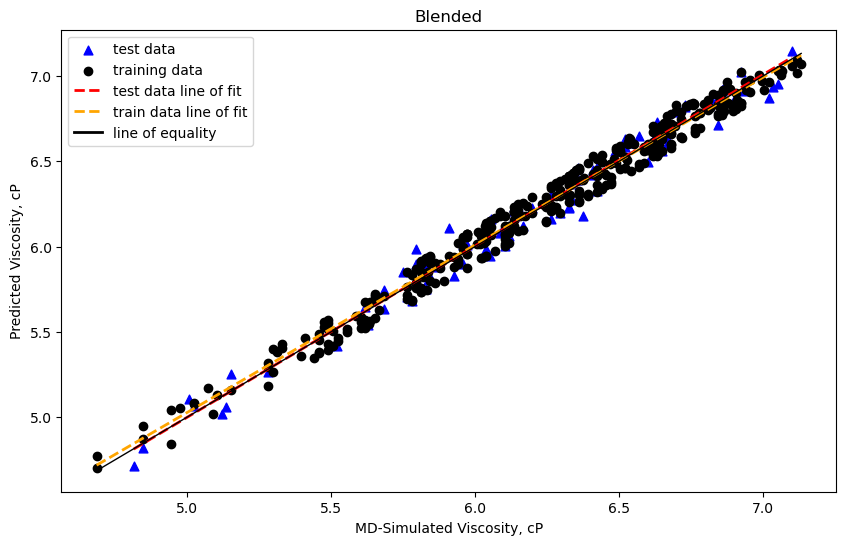

In [58]:
# Plot predicted vs Measured for Apparent Viscosity

predicted = Blended_pred_train
predicted2 = Blended_pred

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, predicted2 , c='blue', marker = "^", s = 40, label ='test data ')
ax.scatter(y_train, predicted, c= 'black', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1).flatten())(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1).flatten())(np.unique(y_train)),color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('Blended')
ax.set_xlabel('MD-Simulated Viscosity, cP')
ax.set_ylabel('Predicted Viscosity, cP')


r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3 )}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3 )}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2,line3])

plt.legend(handles=handles)
plt.savefig('viscosity_BL1.png', dpi=300, bbox_inches='tight')
plt.show()

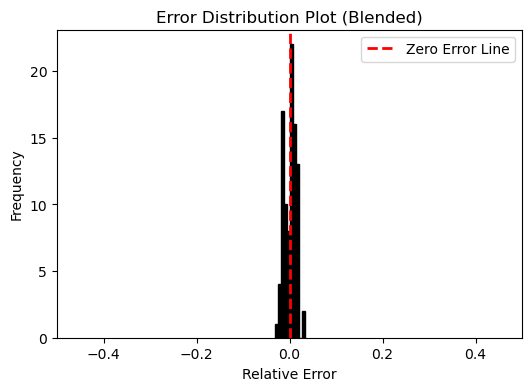

In [59]:
# Calculate the relative errors
relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(6, 4))
plt.hist(relative_errors, bins=10, edgecolor='k', color='black')
plt.title('Error Distribution Plot (Blended)')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(False)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

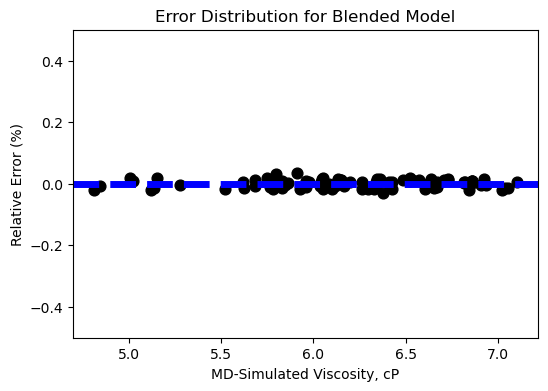

In [60]:
# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, relative_errors, c='black', marker='o', s=60)
plt.axhline(0, color='blue', linestyle='--', lw=5)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for Blended Model')
plt.xlabel('MD-Simulated Viscosity, cP')
plt.ylabel('Relative Error (%)')
plt.grid(False)
plt.savefig('viscosity_BL2.png', dpi=300, bbox_inches='tight')
plt.show()

Evaluation

In [61]:
models_train =[]
models_test =[]

models_train.append(('SVR', SVR_pred_train))
models_train.append(('KNN', KNN_pred_train))
models_train.append(('DT', CART_pred_train))
models_train.append(('LGBM', LGBM_pred_train))
models_train.append(('MLPR', PR_pred_train))
models_train.append(('Super learner', Super_pred_train))
models_train.append(('Blended', Blended_pred_train))





models_test.append(('SVR', SVR_pred))
models_test.append(('KNN', KNN_pred))
models_test.append(('DT', CART_pred))
models_test.append(('LGBM', LGBM_pred))
models_test.append(('MLPR', PR_pred))
models_test.append(('Super learner', Super_pred))
models_test.append(('Blended', Blended_pred))

MSE

In [62]:
# Compare Models using MSE for train set
results = {}

# Evaluate each model in turn
for name, predict_val in models_train:
    cv_results = mean_squared_error(y_train, predict_val, squared=True)
    cv_results = round(np.abs(cv_results), 3 )
    results[name] = cv_results

mse_train = pd.DataFrame(results, index =['mse_train',] )

In [63]:
# Compare Models using MSE for test set
results = {}

# Evaluate each model in turn
for name, predict_val in models_test:
    cv_results = mean_squared_error(y_test, predict_val,squared=True)
    cv_results = round(np.abs(cv_results), 3 )
    results[name] = cv_results

mse_test = pd.DataFrame(results, index =['mse_test',] )

RMSE

In [64]:
# Compare Models using RMSE for train set
results = {}

# Evaluate each model in turn

for name, predict_val in models_train:
    cv_results = mean_squared_error(y_train, predict_val, squared=False)
    cv_results = round(np.abs(cv_results), 3 )
    results[name] = cv_results

rmse_train = pd.DataFrame(results, index =['rmse_train',] )

In [65]:
# Compare Models using MSE for test set
results = {}

# Evaluate each model in turn

for name, predict_val in models_test:
    cv_results = mean_squared_error(y_test, predict_val,squared=False)
    cv_results = round(np.abs(cv_results), 3 )
    results[name] = cv_results

rmse_test = pd.DataFrame(results, index =['rmse_test',] )

MAE

In [66]:
# Compare Models using MAE for train set
results = {}

# Evaluate each model in turn

for name, predict_val in models_train:
    cv_results = mean_absolute_error(y_train, predict_val)
    cv_results = round(np.abs(cv_results), 3 )
    results[name] = cv_results

mae_train = pd.DataFrame(results, index =['mae_train',] )

In [67]:
# Compare Models using MAE for test set

results = {}

# Evaluate each model in turn
for name, predict_val in models_test:
    cv_results = mean_absolute_error(y_test, predict_val)
    cv_results = round(np.abs(cv_results), 3 )
    results[name] = cv_results

mae_test = pd.DataFrame(results, index =['mae_test',] )

R SQUARED

In [68]:
# Compare Models using R-squared for training set
results = {}

# Evaluate each model in turn
for name, predict_val in models_train:
    cv_results = round(r2_score(y_train, predict_val), 3 )
    results[name] = cv_results

r2_train = pd.DataFrame(results, index =['r2_train',] )

In [69]:
# Compare Models using R-squared for test set
results = {}

# Evaluate each model in turn
for name, predict_val in models_test:
    cv_results = round(r2_score(y_test, predict_val), 3 )
    results[name] = cv_results

r2_test = pd.DataFrame(results, index =['r2_test',] )

In [70]:
output = pd.concat([
                    rmse_train, rmse_test, 
                    mae_train, mae_test,
                    r2_train, r2_test,] )
output

,SVR,KNN,DT,LGBM,MLPR,Super learner,Blended
rmse_train,0.076,0.115,0.098,0.115,0.129,0.067,0.067
rmse_test,0.102,0.209,0.174,0.166,0.156,0.099,0.080
mae_train,0.067,0.095,0.066,0.088,0.104,0.056,0.058
mae_test,0.082,0.144,0.125,0.121,0.126,0.078,0.070
r2_train,0.978,0.949,0.963,0.949,0.937,0.983,0.983
r2_test,0.963,0.846,0.893,0.903,0.914,0.965,0.977


In [71]:
# Create a new DataFrame with the specific values
new_data = pd.DataFrame({
    'Temperature': [300],
    'SDS': [0.18],
    'Pressure': [220],
    'Salinity': [0.2429]
})

# Scale the new data using the same scaler fitted on the training data
new_data_scaled = scaler.transform(new_data)

# Use the fitted model to make predictions on the new data
new_viscosity_pred = fitted_SVR.predict(new_data_scaled)
print("Predicted Viscosity:", new_viscosity_pred)

Predicted Viscosity: [6.06741851]


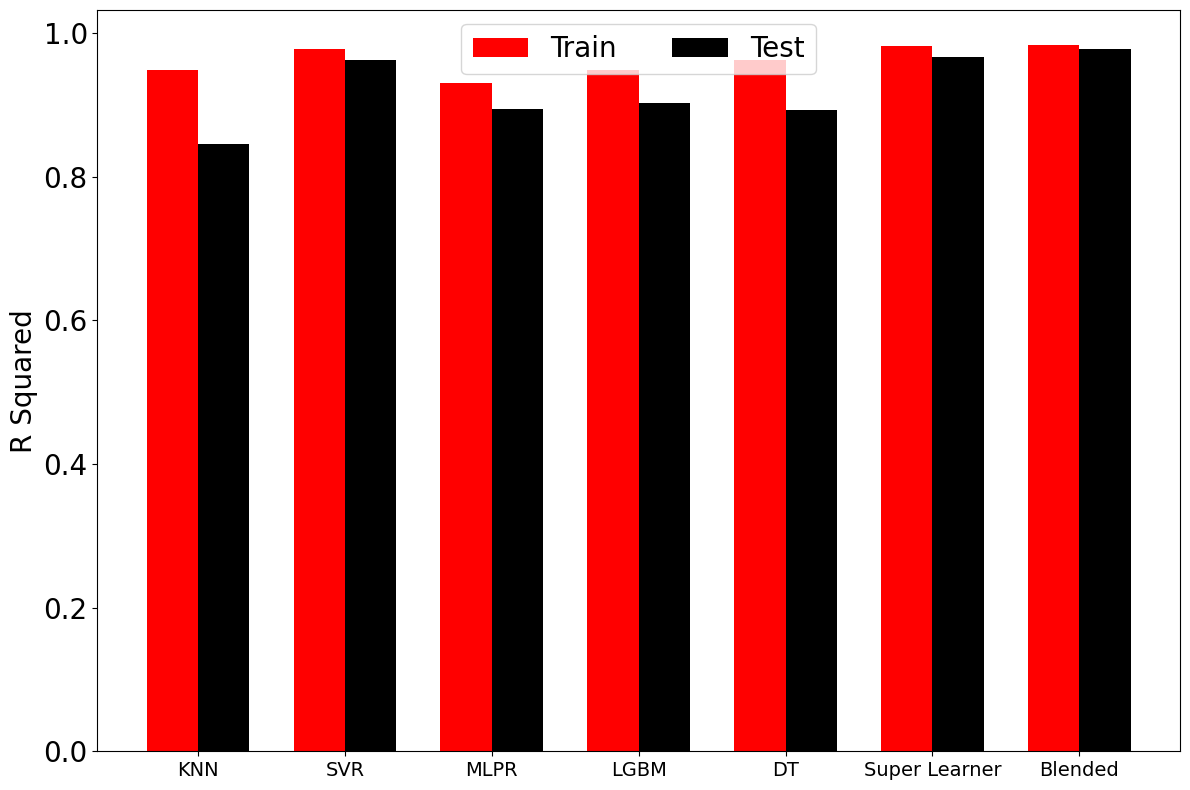

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the models
models = ['KNN', 'SVR', 'MLPR', 'LGBM', 'DT', 'Super Learner', 'Blended']
train_R2 = [0.949, 0.978, 0.930, 0.949, 0.963, 0.982, 0.983]
test_R2 = [0.846, 0.963, 0.894, 0.903, 0.893, 0.967, 0.978]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, train_R2, width, label='Train', color='red')
rects2 = ax.bar(x + width/2, test_R2, width, label='Test', color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_xlabel('Models')
ax.set_ylabel('R Squared', fontsize=20)
#ax.set_title('Train and Test R2 Scores for Each Model')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14)
# Adjust y-axis tick label font size
ax.tick_params(axis='y', labelsize=20)  # Adjust font size for y-axis tick labels
ax.legend(ncol= 2, fontsize= 20)

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.savefig('R2.png')
plt.show()


       Temperature         SDS    Pressure    Salinity   Viscosity
count   462.000000  462.000000  462.000000  462.000000  462.000000
mean    348.138528    0.171212  127.272727    0.280011    6.236311
std      58.938534    0.035608   41.405975    0.031551    0.516467
min     300.000000    0.110000  100.000000    0.219800    4.685100
25%     300.000000    0.150000  100.000000    0.251225    5.880525
50%     300.000000    0.180000  100.000000    0.279900    6.326898
75%     380.000000    0.210000  160.000000    0.305925    6.646764
max     460.000000    0.240000  220.000000    0.342100    7.132300


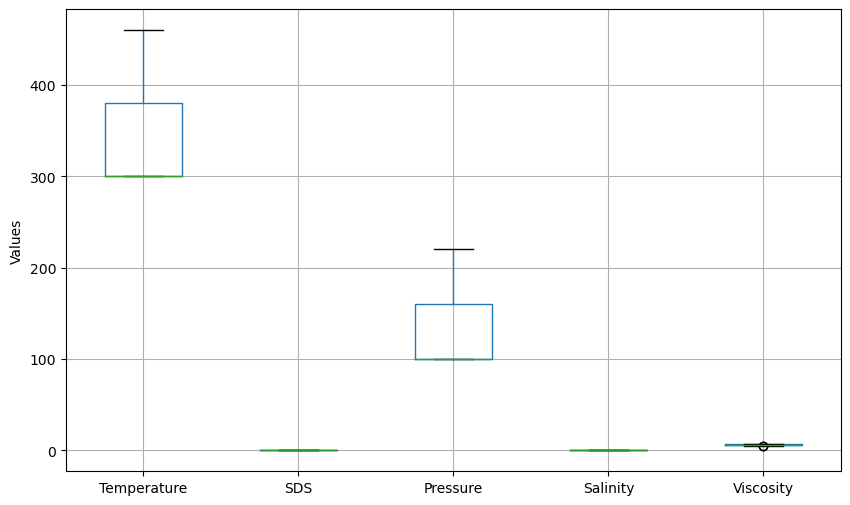

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the provided CSV file
df = pd.read_csv('IOR_data_final.csv')

# Display descriptive statistics to understand the distribution of the data
print(df.describe())

# Create box plots for all columns to check for outliers, missing values, and anomalies
fig, ax = plt.subplots(figsize=(10, 6))
df.boxplot(ax=ax)
#ax.set_title('Box Plot of All Variables')
ax.set_ylabel('Values')
ax.grid(True)

plt.show()


Descriptive Statistics of the Dataset:

       Temperature         SDS    Pressure    Salinity   Viscosity
count   462.000000  462.000000  462.000000  462.000000  462.000000
mean    348.138528    0.171212  127.272727    0.280011    6.236311
std      58.938534    0.035608   41.405975    0.031551    0.516467
min     300.000000    0.110000  100.000000    0.219800    4.685100
25%     300.000000    0.150000  100.000000    0.251225    5.880525
50%     300.000000    0.180000  100.000000    0.279900    6.326898
75%     380.000000    0.210000  160.000000    0.305925    6.646764
max     460.000000    0.240000  220.000000    0.342100    7.132300

Missing values in each column:
Temperature    0
SDS            0
Pressure       0
Salinity       0
Viscosity      0
dtype: int64

Missing values after imputation:
Temperature    0
SDS            0
Pressure       0
Salinity       0
Viscosity      0
dtype: int64

Outliers detected in each numerical column:
Temperature    0
SDS            0
Pressure       0

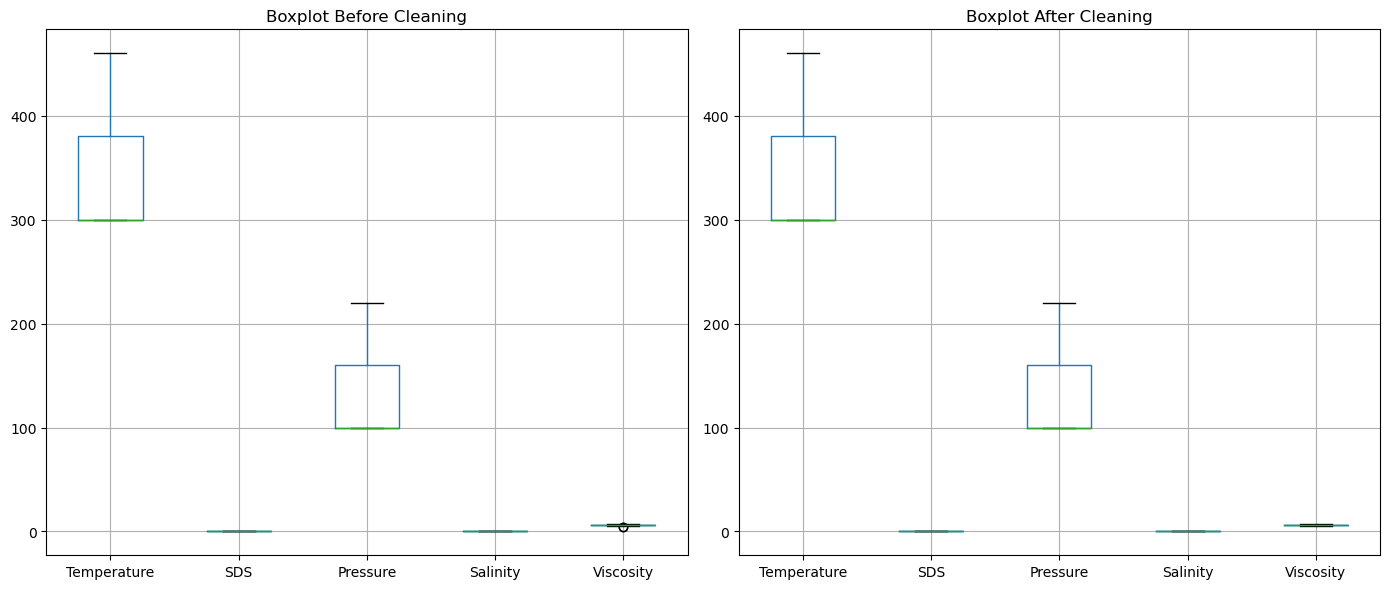


Descriptive Statistics After Cleaning:

       Temperature         SDS    Pressure    Salinity   Viscosity
count   462.000000  462.000000  462.000000  462.000000  462.000000
mean    348.138528    0.171212  127.272727    0.280011    6.243418
std      58.938534    0.035608   41.405975    0.031551    0.506245
min     300.000000    0.110000  100.000000    0.219800    4.813900
25%     300.000000    0.150000  100.000000    0.251225    5.908700
50%     300.000000    0.180000  100.000000    0.279900    6.327099
75%     380.000000    0.210000  160.000000    0.305925    6.646764
max     460.000000    0.240000  220.000000    0.342100    7.132300


In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy import stats

# Load the data from the provided CSV file
df = pd.read_csv('IOR_data_final.csv')

# Display descriptive statistics to understand the distribution of the data
print("Descriptive Statistics of the Dataset:\n")
print(df.describe())

# 1. Checking for Missing Values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Handle missing values using imputation (replacing missing values with the median)
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Check after imputation
print("\nMissing values after imputation:")
print(df_imputed.isnull().sum())

# 2. Detecting Outliers using Z-Score
z_scores = stats.zscore(df_imputed.select_dtypes(include=[float, int]))
outliers = (z_scores > 3).sum(axis=0)  # Count of outliers per column
print("\nOutliers detected in each numerical column:")
print(outliers)

# Handling outliers - replace with median if outlier
for column in df_imputed.select_dtypes(include=[float, int]).columns:
    median_value = df_imputed[column].median()
    df_imputed[column] = pd.Series(
        np.where(np.abs(stats.zscore(df_imputed[column])) > 3, median_value, df_imputed[column])
    )

# 3. Visualize Boxplots Before and After Cleaning (Handling Missing and Outlier Data)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot before cleaning (with potential missing values and outliers)
df.boxplot(ax=axes[0])
axes[0].set_title('Boxplot Before Cleaning')

# Boxplot after cleaning (after imputation and outlier handling)
df_imputed.boxplot(ax=axes[1])
axes[1].set_title('Boxplot After Cleaning')

plt.tight_layout()
# Save the figure
plt.savefig('Boxplots_Before_After_Cleaning.png')

plt.show()

# 4. Final Data Quality Check: Descriptive Stats After Cleaning
print("\nDescriptive Statistics After Cleaning:\n")
print(df_imputed.describe())

# 5. Save the cleaned dataset for further analysis or model training
df_imputed.to_csv('cleaned_IOR_data.csv', index=False)
